**Logisitc Regression**

Task1: Data Processing

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
import category_encoders as ce

# Mount Google Drive
drive.mount('/content/drive')
data_filename = '/content/drive/My Drive/data/train.gz'

n = 40428967 # Total number of records in the dataset
s = 500000 # Desired sample size

# Read the .gz file directly with pandas
data_train = pd.read_csv(data_filename, compression='gzip', nrows=s)

# Display the first few rows of the sample data
print(data_train.head())

Mounted at /content/drive
             id  click      hour    C1  banner_pos   site_id site_domain  \
0  1.000009e+18      0  14102100  1005           0  1fbe01fe    f3845767   
1  1.000017e+19      0  14102100  1005           0  1fbe01fe    f3845767   
2  1.000037e+19      0  14102100  1005           0  1fbe01fe    f3845767   
3  1.000064e+19      0  14102100  1005           0  1fbe01fe    f3845767   
4  1.000068e+19      0  14102100  1005           1  fe8cc448    9166c161   

  site_category    app_id app_domain  ... device_type device_conn_type    C14  \
0      28905ebd  ecad2386   7801e8d9  ...           1                2  15706   
1      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
2      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
3      28905ebd  ecad2386   7801e8d9  ...           1                0  15706   
4      0569f928  ecad2386   7801e8d9  ...           1                0  18993   

   C15  C16   C17  C18  C19   

In [3]:
# Check for missing values
print("\nMissing values in each column:")
missing_values = data_train.isnull().sum()
print(missing_values[missing_values > 0])



Missing values in each column:
Series([], dtype: int64)


In [4]:
# Drop unnecessary columns
columns_to_drop = ['id', 'hour']
data_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Handle outliers
# Capping outliers at the 98th percentile
for col in ['C15', 'C16', 'C19', 'C21']:
    percentiles = data_train[col].quantile(0.98)
    if percentiles < 0.5 * data_train[col].max():
        data_train[col] = np.where(data_train[col] >= percentiles, percentiles, data_train[col])


In [5]:
# Define numerical and categorical variables
numerical = []
categorical = []

for col in data_train.columns:
    if data_train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)

print("Numerical columns:", numerical)
print("\nCategorical columns:", categorical)



Numerical columns: ['click', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

Categorical columns: ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']



Click distribution:
click
0    0.835926
1    0.164074
Name: proportion, dtype: float64


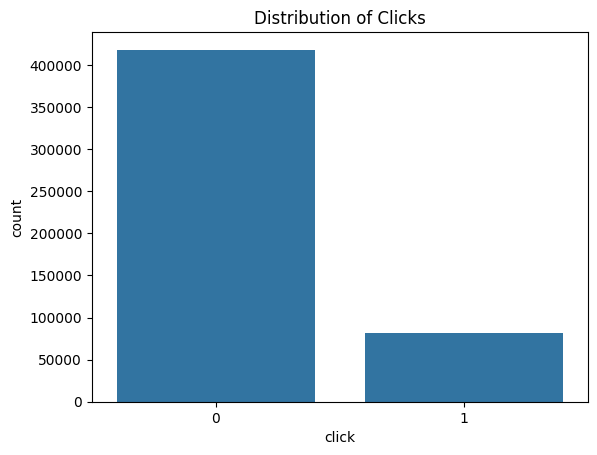

In [6]:
# Plot the distribution of the target variable
print("\nClick distribution:")
print(data_train.click.value_counts(normalize=True))
plt.figure()
sns.countplot(x='click', data=data_train)
plt.title("Distribution of Clicks")
plt.show()



Sampled data click distribution:
click
0    0.8374
1    0.1626
Name: proportion, dtype: float64


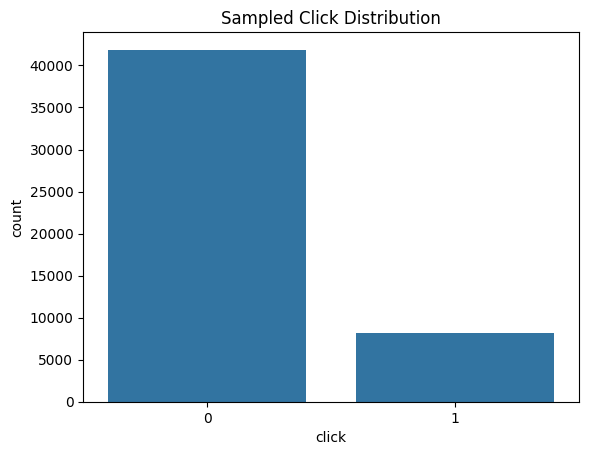

In [7]:
# Sample data
# This code samples 10% of the data from data_train, separates the features into X, and assigns the target variable to y
sampled_data = data_train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['click'], axis=1)
y = sampled_data['click']

# Verify the sampling ratio
print("\nSampled data click distribution:")
print(y.value_counts(normalize=True))
plt.figure()
sns.countplot(x=y)
plt.title("Sampled Click Distribution")
plt.show()


Original dataset shape: Counter({0: 41870, 1: 8130})
Resampled dataset shape: Counter({1: 41870, 0: 41870})


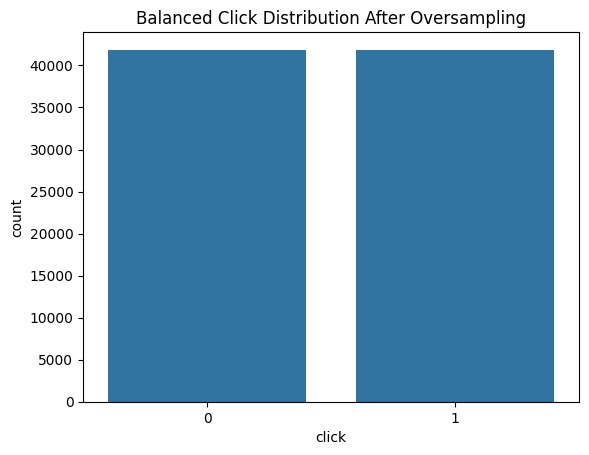

In [8]:
# Apply Target Encoding to categorical features
target_encoder = ce.TargetEncoder()
X_encoded = target_encoder.fit_transform(X, y)

# Handle class imbalance using Random Oversampling
random_sample = RandomOverSampler(random_state=42)
x_new, y_new = random_sample.fit_resample(X_encoded, y)

from collections import Counter
print('Original dataset shape:', Counter(y))
print('Resampled dataset shape:', Counter(y_new))
plt.figure()
sns.countplot(x=y_new)
plt.title("Balanced Click Distribution After Oversampling")
plt.show()


Task 2: Logistic Regression

The logistic function is defined as:

$$
h_{\theta}(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

Where:

- \( h_{\theta}(x) \) is the predicted probability of the positive class (click = 1).
- \( \theta \) is the vector of weights (parameters).
- \( x \) is the feature vector.

The cost function used for logistic regression is the binary cross-entropy loss, defined as:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h_{\theta}(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)})) \right]
$$

Where:

- \( m \) is the number of training examples.
- \( y^{(i)} \) is the actual label (0 or 1) for the \( i \)-th example.
- \( h_{\theta}(x^{(i)}) \) is the predicted probability.

The gradient of the cost function with respect to \( \theta \) is given by:

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right) x_j^{(i)}
$$



<ipython-input-9-75cc994425ec>:45: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


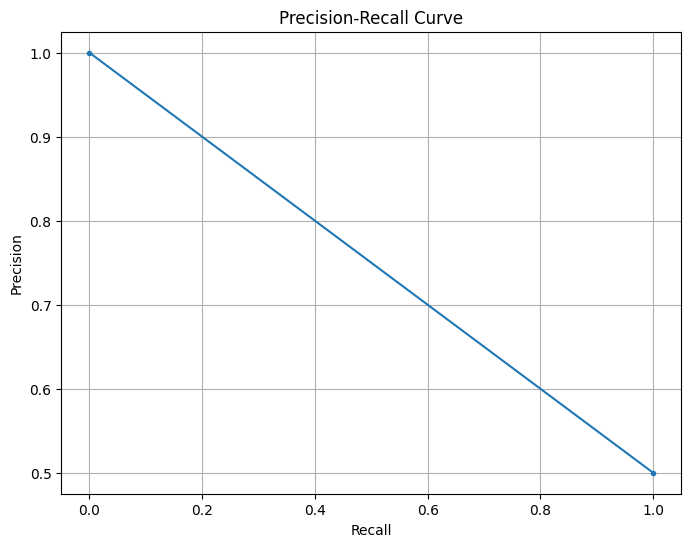

Final precision: 1.0
Final recall: 0.0


In [9]:
# Logistic Regression Class
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, num_epochs=1000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.theta = None

    def fit(self, X, y):
        """
        Fit the logistic regression model using Stochastic Gradient Descent (SGD).

        Parameters:
        X (numpy array): Features
        y (numpy array): Target variable (0 or 1)
        """
         # Convert Pandas DataFrame to NumPy array
        X = X.values  # Added this line to convert X to a NumPy array

        m, n = X.shape  # Number of samples (m) and number of features (n)
        self.theta = np.zeros(n)  # Initialize weights to zeros

        # Perform SGD for a specified number of epochs
        for epoch in range(self.num_epochs):
            for i in range(m):
                # Compute the linear combination of inputs and weights
                linear_model = np.dot(X[i], self.theta)

                # Apply the sigmoid function to get the predicted probability
                prediction = self.sigmoid(linear_model)

                # Update the weights using the gradient descent update rule
                gradient = (prediction - y[i]) * X[i]
                self.theta -= self.learning_rate * gradient

    def sigmoid(self, z):
        """
        Compute the sigmoid function.

        Parameters:
        z (numpy array): Input value or array

        Returns:
        numpy array: Sigmoid output
        """
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        """
        Predict class labels for the input samples.

        Parameters:
        X (numpy array): Input features

        Returns:
        numpy array: Predicted class labels (0 or 1)
        """
        # Convert Pandas DataFrame to NumPy array if necessary
        if isinstance(X, pd.DataFrame):  # Check if X is a DataFrame
            X = X.values  # Convert to NumPy array

        return self.sigmoid(np.dot(X, self.theta)) >= 0.5  # Use 0.5 as the threshold

# Instantiate and train the model
log_reg_sgd = LogisticRegressionSGD(learning_rate=0.01, num_epochs=1000)
log_reg_sgd.fit(x_new, y_new)  # Using the resampled data

# Predictions on the training data
y_pred = log_reg_sgd.predict(x_new)

# Get predicted probabilities for precision-recall curve
y_scores = log_reg_sgd.sigmoid(np.dot(x_new, log_reg_sgd.theta))

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_new, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Optional: Print the final precision and recall scores at a certain threshold (e.g., 0.5)
print("Final precision:", precision[-1])
print("Final recall:", recall[-1])